# PHS Simulation in Long-Term

Here we want to perform the multi-market optimization with the hourly resolution but for the long-duration of the time (e.g. 15 years) - This version models the yearly model ( not monthly)

## Scneario 1: with constant cycle cost


In [3]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd





# Function to run the optimization model for a given month
def run_model_for_year(df_lambda, start_date, end_date, Gmax_gen, ResLev_min, ResLev_max, ResLev_init, delta_FFR, delta_FCR_N, delta_FCR_D,spot_active,FCRD_future,FCRN_future,cycle_cost,etta_pump,etta_gen,mFRR_CM_future, mFRR_EAM_future, aFRR_CM_future,FFR_future,spot_future,delta_mFRR_EAM):
    # Filter the data based on the start and end dates
    df_lambda_month = df_lambda[(df_lambda['Date'] >= start_date) & (df_lambda['Date'] <= end_date)]
    
    # Update the tMax based on the filtered data
    tMax = len(df_lambda_month)
    
    # Create a time index based on the filtered data
    time_index = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Create a dictionary for Gmax_pump based on the conditions
    Gmax_pump_dict = {}
    for dt in time_index:
        if (4 <= dt.month <= 10) or (22 <= dt.hour or dt.hour < 6) or (dt.weekday() == [5,6]):
            Gmax_pump_dict[dt] = Gmax_gen
        else:
            Gmax_pump_dict[dt] = Gmax_gen

    # Map integer time index to datetime objects
    time_index_mapping = {i: dt for i, dt in enumerate(time_index)}

    # define a set of time periods and parameters
    model = ConcreteModel()
    model.T = Set(initialize=range(tMax))
    model.T_order = Set(initialize=time_index, ordered=True)
    model.tamx = Param(initialize=tMax)
    model.Gmax_gen = Param(initialize=Gmax_gen)
    model.Gmax_pump_dict = Param(model.T_order, initialize=Gmax_pump_dict)
    model.ResLev_min = Param(initialize=ResLev_min)
    model.ResLev_max = Param(initialize=ResLev_max)
    model.delta_FFR = Param(initialize=delta_FFR)
    model.delta_FCR_N = Param(initialize=delta_FCR_N)
    model.delta_FCR_D = Param(initialize=delta_FCR_D)
    model.delta_mFRR_EAM = Param(initialize=delta_mFRR_EAM)
    model.ResLev_init = Param(initialize=ResLev_init)
    model.etta_gen = Param(initialize=etta_gen)
    model.etta_pump = Param(initialize=etta_pump)

    def Gmax_pump_rule(model, t):
        dt = time_index_mapping[t]
        return Gmax_pump_dict[dt]
    model.Gmax_pump = Param(model.T, initialize=Gmax_pump_rule, within=NonNegativeReals)

    # Extract the relevant columns
    lambda_FFR = df_lambda_month['FFR Pris (EUR/MW)'].to_list()
    lambda_FCR_N = df_lambda_month['FCR-N Pris (EUR/MW)'].to_list()
    lambda_FCR_D_up = df_lambda_month['FCR-D upp Pris (EUR/MW)'].to_list()
    lambda_FCR_D_down = df_lambda_month['FCR-D ned Pris (EUR/MW)'].to_list()
    lambda_aFRR_CM_up = df_lambda_month['aFRR Upp Pris (EUR/MW)'].to_list()
    lambda_aFRR_CM_down = df_lambda_month['aFRR Ned Pris (EUR/MW)'].to_list()
    lambda_mFRR_CM_up = df_lambda_month['mFRR Upp Pris (EUR/MW)'].to_list()
    lambda_mFRR_CM_down = df_lambda_month['mFRR Ned Pris (EUR/MW)'].to_list()
    lambda_mFRR_EAM_up = df_lambda_month['mFRR Upp EAM Pris (EUR/MW)'].to_list()
    lambda_mFRR_EAM_down = df_lambda_month['mFRR Ned EAM Pris (EUR/MW)'].to_list()
    lambda_spot = df_lambda_month['SPOT'].to_list()

    # Create dictionaries for initialization
    lambda_FFR_dict = {t: lambda_FFR[t] for t in model.T}
    lambda_FCR_N_dict = {t: lambda_FCR_N[t] for t in model.T}
    lambda_FCR_D_up_dict = {t: lambda_FCR_D_up[t] for t in model.T}
    lambda_FCR_D_down_dict = {t: lambda_FCR_D_down[t] for t in model.T}
    lambda_aFRR_CM_up_dict = {t: lambda_aFRR_CM_up[t] for t in model.T}
    lambda_aFRR_CM_down_dict = {t: lambda_aFRR_CM_down[t] for t in model.T}
    lambda_mFRR_CM_up_dict = {t: lambda_mFRR_CM_up[t] for t in model.T}
    lambda_mFRR_CM_down_dict = {t: lambda_mFRR_CM_down[t] for t in model.T}
    lambda_mFRR_EAM_up_dict = {t: lambda_mFRR_EAM_up[t] for t in model.T}
    lambda_mFRR_EAM_down_dict = {t: lambda_mFRR_EAM_down[t] for t in model.T}
    lambda_spot_dict = {t: lambda_spot[t] for t in model.T}




    # Define binary decision variables
    model.u_gen = Var(model.T, domain=Binary)
    model.u_pump = Var(model.T, domain=Binary)


    # Define continuous decision variables
    model.p_FFR_gen = Var(model.T, domain=NonNegativeReals)
    # fix p_FF_gen to zero
    model.p_FFR_gen.fix(0)
    model.p_FCR_N = Var(model.T, domain=NonNegativeReals)
    #model.p_FCR_N_pump = Var(model.T, domain=NonNegativeReals)
    model.p_FCR_D_up = Var(model.T, domain=NonNegativeReals)
    model.p_FCR_D_down = Var(model.T, domain=NonNegativeReals)
    model.p_aFRR_CM_up = Var(model.T, domain=NonNegativeReals)
    model.p_aFRR_CM_down = Var(model.T, domain=NonNegativeReals)
    model.p_mFRR_CM_up = Var(model.T, domain=NonNegativeReals)
    model.p_mFRR_CM_down = Var(model.T, domain=NonNegativeReals)
    model.p_mFRR_EAM_up = Var(model.T, domain=NonNegativeReals)
    model.p_mFRR_EAM_down = Var(model.T, domain=NonNegativeReals)

    model.p_spot_pump = Var(model.T, domain=NonNegativeReals)
    model.p_spot_gen = Var(model.T, domain=NonNegativeReals)
    model.ResLev = Var(model.T, domain=NonNegativeReals)
    model.cycle_number = Var(model.T, domain=NonNegativeReals)

    model.p_gen_total = Var(model.T, domain=NonNegativeReals)
    model.p_pump_total = Var(model.T, domain=NonNegativeReals)

    # Define the parameters
    model.spot_active = Param(initialize=spot_active)
    model.mFRR_CM_future = Param(initialize=mFRR_CM_future)
    model.mFRR_EAM_future = Param(initialize=mFRR_EAM_future)
    model.aFRR_CM_future = Param(initialize=aFRR_CM_future)
    model.cycle_cost = Param(initialize=cycle_cost)
    model.FCRD_future = Param(initialize=FCRD_future)
    model.FCRN_future = Param(initialize=FCRN_future)
    model.FFR_future = Param(initialize=FFR_future)
    model.spot_future = Param(initialize=spot_future)

    if model.mFRR_CM_future == 0:
        model.p_mFRR_CM_up.fix(0)
        model.p_mFRR_CM_down.fix(0)
    if model.mFRR_EAM_future == 0:
        model.p_mFRR_EAM_up.fix(0)
        model.p_mFRR_EAM_down.fix(0)
    if model.aFRR_CM_future == 0:
        model.p_aFRR_CM_up.fix(0)
        model.p_aFRR_CM_down.fix(0)
    if model.spot_active == 0:
        model.p_spot_pump.fix(0)
        model.p_spot_gen.fix(0)
    if model.FFR_future == 0:
        model.p_FFR_gen.fix(0)
    if model.FCRN_future == 0:
        model.p_FCR_N.fix(0)
    if model.FCRD_future == 0:
        model.p_FCR_D_up.fix(0)
        model.p_FCR_D_down.fix(0)


     # limit the upper bound prices to be positive defined ffor each market

    # Define maximum price limits (you can set these manually)
    max_price_FFR = 1000  # Example maximum price for FFR
    max_price_FCR_N = 1000  # Example maximum price for FCR-N
    max_price_FCR_D_up = 1000  # Example maximum price for FCR-D up
    max_price_FCR_D_down = 1000  # Example maximum price for FCR-D down
    max_price_aFRR_CM_up = 1000  # Example maximum price for aFRR_CM up
    max_price_aFRR_CM_down = 1000  # Example maximum price for aFRR_CM down
    max_price_mFRR_CM_up = 500  # Example maximum price for mFRR_CM up
    max_price_mFRR_CM_down = 500  # Example maximum price for mFRR_CM down
    max_price_mFRR_EAM_up = 500  # Example maximum price for mFRR_EAM up
    max_price_mFRR_EAM_down = 500  # Example maximum price for mFRR_EAM down
    max_price_spot = 1000  # Example maximum price for spot market

    # Modify the initialization to apply the max price cap
    lambda_FFR_dict = {t: min(lambda_FFR[t], max_price_FFR) for t in model.T}
    lambda_FCR_N_dict = {t: min(lambda_FCR_N[t], max_price_FCR_N) for t in model.T}
    lambda_FCR_D_up_dict = {t: min(lambda_FCR_D_up[t], max_price_FCR_D_up) for t in model.T}
    lambda_FCR_D_down_dict = {t: min(lambda_FCR_D_down[t], max_price_FCR_D_down) for t in model.T}
    lambda_aFRR_CM_up_dict = {t: min(lambda_aFRR_CM_up[t], max_price_aFRR_CM_up) for t in model.T}
    lambda_aFRR_CM_down_dict = {t: min(lambda_aFRR_CM_down[t], max_price_aFRR_CM_down) for t in model.T}
    lambda_mFRR_CM_up_dict = {t: min(lambda_mFRR_CM_up[t], max_price_mFRR_CM_up) for t in model.T}
    lambda_mFRR_CM_down_dict = {t: min(lambda_mFRR_CM_down[t], max_price_mFRR_CM_down) for t in model.T}
    lambda_mFRR_EAM_up_dict = {t: min(lambda_mFRR_EAM_up[t], max_price_mFRR_EAM_up) for t in model.T}
    lambda_mFRR_EAM_down_dict = {t: min(lambda_mFRR_EAM_down[t], max_price_mFRR_EAM_down) for t in model.T}
    lambda_spot_dict = {t: min(lambda_spot[t], max_price_spot) for t in model.T}

    # Define the Params in the model
    model.lambda_FFR = Param(model.T, initialize=lambda_FFR_dict)
    model.lambda_FCR_N = Param(model.T, initialize=lambda_FCR_N_dict)
    model.lambda_FCR_D_up = Param(model.T, initialize=lambda_FCR_D_up_dict)
    model.lambda_FCR_D_down = Param(model.T, initialize=lambda_FCR_D_down_dict)
    model.lambda_aFRR_CM_up = Param(model.T, initialize=lambda_aFRR_CM_up_dict)
    model.lambda_aFRR_CM_down = Param(model.T, initialize=lambda_aFRR_CM_down_dict)
    model.lambda_mFRR_CM_up = Param(model.T, initialize=lambda_mFRR_CM_up_dict)
    model.lambda_mFRR_CM_down = Param(model.T, initialize=lambda_mFRR_CM_down_dict)
    model.lambda_mFRR_EAM_up = Param(model.T, initialize=lambda_mFRR_EAM_up_dict)
    model.lambda_mFRR_EAM_down = Param(model.T, initialize=lambda_mFRR_EAM_down_dict)
    model.lambda_spot = Param(model.T, initialize=lambda_spot_dict)


    model.delta_mFRR_EAM_Actual = Param(initialize=0.1)

    ## Define the objective function
    model.obj = Objective(expr=sum(model.lambda_spot[t]*(model.p_spot_gen[t]- model.p_spot_pump[t])*model.spot_active*model.spot_future
                                   + model.lambda_FCR_N[t]*model.p_FCR_N[t]*model.FCRN_future 
                                   + model.lambda_FFR[t]*model.p_FFR_gen[t]* model.FFR_future
                                   + model.lambda_FCR_D_down[t]*model.p_FCR_D_down[t]*model.FCRD_future                                             # capacity payment for FCR_D_down
                                   - model.p_FCR_D_down[t]*model.delta_FCR_D* model.lambda_spot[t]                                                  # energy payment for FCR_D_down
                                   + model.p_FCR_D_up[t]*model.delta_FCR_D* model.lambda_spot[t]                                                    # energy payment for FCR_D_up
                                   + model.lambda_FCR_D_up[t]*model.p_FCR_D_up[t]*model.FCRD_future 
                                   + model.lambda_aFRR_CM_up[t]*model.p_aFRR_CM_up[t]*model.aFRR_CM_future                                          # capacity payment for aFRR_CM_up
                                   + model.lambda_aFRR_CM_down[t]*model.p_aFRR_CM_down[t]*model.aFRR_CM_future                                      # capacity payment for aFRR_CM_down
                                   + model.lambda_mFRR_CM_up[t]*model.p_mFRR_CM_up[t]*model.mFRR_CM_future                                          # capacity payment for mFRR_CM_up
                                   + model.lambda_mFRR_CM_down[t]*model.p_mFRR_CM_down[t]*model.mFRR_CM_future                                      # capacity payment for mFRR_CM_down
                                   + model.lambda_mFRR_EAM_up[t]*model.p_mFRR_EAM_up[t]*model.mFRR_EAM_future* model.delta_mFRR_EAM_Actual          # energy payment for mFRR_EAM_up 
                                   - model.lambda_mFRR_EAM_down[t]*model.p_mFRR_EAM_down[t]*model.mFRR_EAM_future* model.delta_mFRR_EAM_Actual      # energy payment for mFRR_EAM_down
                                   - model.cycle_cost*model.cycle_number[t] for t in model.T), sense=maximize)                                      # capacity payment for FCR_D_up
    



    ## Define the constraints

    def p_gen_total_rule(model, t):
        return model.p_gen_total[t] == (model.p_FFR_gen[t]*model.delta_FFR + model.p_FCR_N[t]*model.delta_FCR_N + 
                                        model.p_FCR_D_up[t] * model.delta_FCR_D + model.p_spot_gen[t]
                                        + model.p_mFRR_EAM_up[t]*model.delta_mFRR_EAM_Actual) / model.etta_gen
    model.p_gen_total_cons = Constraint(model.T, rule=p_gen_total_rule)

    def p_pump_total_rule(model, t):
        return model.p_pump_total[t] == (model.p_FCR_N[t]*model.delta_FCR_N + model.p_FCR_D_down[t]*model.delta_FCR_D +
                                    model.p_mFRR_EAM_down[t]*model.delta_mFRR_EAM_Actual + model.p_spot_pump[t]) * model.etta_pump
    model.p_pump_total_cons = Constraint(model.T, rule=p_pump_total_rule)

    # # Either genarging or charging
    # def gen_pump_rule(model, t):
    #     return model.u_gen[t] + model.u_pump[t] <= 1
    # model.gen_pump_cons = Constraint(model.T, rule=gen_pump_rule)

    # # total genarging power limit by u_gen
    # def gen_power_limit_rule_u_gen(model, t):
    #     return model.p_spot_gen[t] <= model.Gmax_gen*model.u_gen[t]
    # model.gen_power_limit_u_gen = Constraint(model.T, rule=gen_power_limit_rule_u_gen)

    # # total charging power limit by u_pump
    # def ch_power_limit_rule_u_pump(model, t):
    #     return model.p_spot_pump[t] <= model.Gmax_pump[t]*model.u_pump[t]
    # model.ch_power_limit_u_pump = Constraint(model.T, rule=ch_power_limit_rule_u_pump)



    # ResLev update constraint
    def ResLev_update_rule(model, t):
        if t == 0:
            return model.ResLev[t] == model.ResLev_init
        else:
            ResLev_gen = (model.p_FFR_gen[t]*model.delta_FFR + model.p_FCR_N[t]*model.delta_FCR_N +
                          model.p_FCR_D_up[t] * model.delta_FCR_D + model.p_spot_gen[t]
                          + model.p_mFRR_EAM_up[t]*model.delta_mFRR_EAM_Actual) / model.etta_gen
            ResLev_pump = (model.p_FCR_N[t]*model.delta_FCR_N + model.p_FCR_D_down[t]*model.delta_FCR_D +
                      model.p_mFRR_EAM_down[t]*model.delta_mFRR_EAM_Actual + model.p_spot_pump[t]) * model.etta_pump
            return model.ResLev[t] == model.ResLev[t-1] - ResLev_pump + ResLev_gen
    model.ResLev_update = Constraint(model.T, rule=ResLev_update_rule)


    # Cycle number calculation
    # New cycle number calculation is based on the genarge power
    def cycle_cost_rule(model, t):
        return model.cycle_number[t] == (model.p_FCR_N[t]*model.delta_FCR_N +
        + model.p_FFR_gen[t]*model.delta_FFR + model.p_FCR_D_up[t] * model.delta_FCR_D + model.p_spot_gen[t]+ model.p_mFRR_EAM_up[t]*model.delta_mFRR_EAM_Actual)
    model.cycle_cost_cons = Constraint(model.T, rule=cycle_cost_rule)

    # Capacity constraints
    def ch_power_limit_rule(model, t):
        return model.p_FCR_N[t] + model.p_FCR_D_down[t] + model.p_spot_pump[t] + model.p_aFRR_CM_down[t] + model.p_mFRR_CM_down[t]<= model.Gmax_pump[t]
    model.ch_power_limit = Constraint(model.T, rule=ch_power_limit_rule)

    def gen_power_limit_rule(model, t):
        return model.p_FFR_gen[t] + model.p_FCR_N[t] + model.p_FCR_D_up[t] + model.p_spot_gen[t]+ model.p_aFRR_CM_up[t] + model.p_mFRR_CM_up[t]<= model.Gmax_gen
    model.gen_power_limit = Constraint(model.T, rule=gen_power_limit_rule)

    # Capacity constraints (EAM Version)
    def ch_power_limit_rule_EAM(model, t):
        return model.p_FCR_N[t] + model.p_FCR_D_down[t] + model.p_spot_pump[t] + model.p_aFRR_CM_down[t] + model.p_mFRR_EAM_down[t]<= model.Gmax_pump[t]
    model.ch_power_limit_EAM = Constraint(model.T, rule=ch_power_limit_rule_EAM)

    def gen_power_limit_rule_EAM(model, t):
        return model.p_FFR_gen[t] + model.p_FCR_N[t] + model.p_FCR_D_up[t] + model.p_spot_gen[t]+ model.p_aFRR_CM_up[t] + model.p_mFRR_EAM_up[t]<= model.Gmax_gen
    model.gen_power_limit_EAM = Constraint(model.T, rule=gen_power_limit_rule_EAM)



    # Reserve constraints for mFRR_CM and mFRR_EAM
    def cap_rule_mFRR_CM_up(model, t):
        return model.p_mFRR_CM_up[t] <= model.p_mFRR_EAM_up[t]    
    model.reserve_rule_mFRR_CM_up = Constraint(model.T, rule=cap_rule_mFRR_CM_up)

    def cap_rule_mFRR_CM_down(model, t):
        return model.p_mFRR_CM_down[t] <= model.p_mFRR_EAM_down[t]
    model.reserve_rule_mFRR_CM_down = Constraint(model.T, rule=cap_rule_mFRR_CM_down)

    # def cap_rule_mFRR_EAM_up(model, t):
    #     return model.p_mFRR_EAM_up[t] <= model.Gmax_gen
    # model.reserve_rule_mFRR_EAM_up = Constraint(model.T, rule=cap_rule_mFRR_EAM_up)

    # def cap_rule_mFRR_EAM_down(model, t):
    #     return model.p_mFRR_EAM_down[t] <= model.Gmax_pump[t]
    # model.reserve_rule_mFRR_EAM_down = Constraint(model.T, rule=cap_rule_mFRR_EAM_down)


    # NEM reserve constraints based on the SVK prequalification process
    def cap_rule_NEM_up(model, t):
        return 1.34*(model.p_FCR_N[t])+ 1*model.p_FCR_D_up[t] + 0.2*model.p_FCR_D_down[t]  <= Gmax_gen
    model.reserve_rule_fcr_nem_up = Constraint(model.T, rule=cap_rule_NEM_up)

    def cap_rule_NEM_down(model, t):
        return 1.34*(model.p_FCR_N[t])+ 0.2*model.p_FCR_D_up[t] + 1*model.p_FCR_D_down[t]  <= model.Gmax_pump[t]
    model.reserve_rule_fcr_nem_down = Constraint(model.T, rule=cap_rule_NEM_down)

    # Enery balance constraint
    def ResLev_update_rule_up_end(model, t):
        if t == 0:
            return model.ResLev[t] == model.ResLev_init
        else:
            return  model.ResLev_max - model.ResLev[t]  >= model.p_FCR_N[t] + 1/3*model.p_FCR_D_down[t] + model.p_mFRR_EAM_down[t]*model.delta_mFRR_EAM
    model.ResLev_update_2_end = Constraint(model.T, rule=ResLev_update_rule_up_end)



    def ResLev_update_rule_up_begin(model, t):
        if t == 0:
            return model.ResLev[t] == model.ResLev_init
        elif t == 1:
            return model.ResLev[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_down[t]
        else:
            return  model.ResLev_max - model.ResLev[t-1]  >= model.p_FCR_N[t] + model.p_mFRR_EAM_down[t]*model.delta_mFRR_EAM + 1/3*model.p_FCR_D_down[t]
    model.ResLev_update_2_begin = Constraint(model.T, rule=ResLev_update_rule_up_begin)

    def ResLev_update_rule_down_end(model, t):
        if t == 0:
            return model.ResLev[t] == model.ResLev_init 
        else:
            return model.ResLev[t] - model.ResLev_min >=  model.p_FCR_N[t] + model.p_mFRR_EAM_up[t]*model.delta_mFRR_EAM + 1/3*model.p_FCR_D_up[t]
            #return model.ResLev[t-1] - model.ResLev[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t] 
    model.ResLev_update_3_end = Constraint(model.T, rule=ResLev_update_rule_down_end)




    def ResLev_update_rule_down_begin(model, t):
        if t == 0:
            return model.ResLev[t] == model.ResLev_init
        elif t == 1:
            return model.ResLev[t] >=  model.p_FCR_N[t] + model.p_mFRR_EAM_up[t]*model.delta_mFRR_EAM + 1/3*model.p_FCR_D_up[t]
        else:
            return model.ResLev[t-1] - model.ResLev_min >=  model.p_FCR_N[t] + model.p_mFRR_EAM_up[t]*model.delta_mFRR_EAM + 1/3*model.p_FCR_D_up[t]
            #return model.ResLev[t-1] - model.ResLev[t] >=  model.p_FCR_N[t] + 1/3*model.p_FCR_D_up[t] 
    model.ResLev_update_3_begin = Constraint(model.T, rule=ResLev_update_rule_down_begin)



    def ResLev_min_rule(model, t):
        return model.ResLev[t] >= model.ResLev_min
    model.ResLev_min_cons = Constraint(model.T, rule=ResLev_min_rule)

    def ResLev_max_rule(model, t):
        return model.ResLev[t] <= model.ResLev_max
    model.ResLev_max_cons = Constraint(model.T, rule=ResLev_max_rule)
    

    # Define the constraint for limiting hihg revenue from FRR markets looking at three hours ahead
    def constraint_mFRR_up(model, t):
        if t < tMax-3:
            return model.p_mFRR_EAM_up[t] + 0.5*model.p_mFRR_EAM_up[t+1] + 0.25*model.p_mFRR_EAM_up[t+2] + 0.125*model.p_mFRR_EAM_up[t+3] <= model.Gmax_gen
        else:
            return Constraint.Skip
    model.constraint_mFRR_up = Constraint(model.T, rule=constraint_mFRR_up)

    def constraint_mFRR_down(model, t):
        if t < tMax-3:
            return model.p_mFRR_EAM_down[t] + 0.5*model.p_mFRR_EAM_down[t+1] + 0.25*model.p_mFRR_EAM_down[t+2] + 0.125*model.p_mFRR_EAM_down[t+3] <= model.Gmax_pump[t]
        else:
            return Constraint.Skip
    model.constraint_mFRR_down = Constraint(model.T, rule=constraint_mFRR_down)

    # Do the same for aFRR markets
    def constraint_aFRR_up(model, t):
        if t < tMax-3:
            return model.p_aFRR_CM_up[t] + 0.5*model.p_aFRR_CM_up[t+1] + 0.25*model.p_aFRR_CM_up[t+2] + 0.125*model.p_aFRR_CM_up[t+3] <= model.Gmax_gen
        else:
            return Constraint.Skip
    model.constraint_aFRR_up = Constraint(model.T, rule=constraint_aFRR_up)

    def constraint_aFRR_down(model, t):
        if t < tMax-3:
            return model.p_aFRR_CM_down[t] + 0.5*model.p_aFRR_CM_down[t+1] + 0.25*model.p_aFRR_CM_down[t+2] + 0.125*model.p_aFRR_CM_down[t+3] <= model.Gmax_pump[t]
        else:
            return Constraint.Skip
    model.constraint_aFRR_down = Constraint(model.T, rule=constraint_aFRR_down)

    


    # Create a solver
    solver = SolverFactory('glpk')

    # Set the solver options
    solver.options['mipgap'] = 0.03  # This sets the gap to 1%

    # Solve the problem
    results = solver.solve(model, tee=False)

    # Collect the results with rounding to two decimal places
    results_data = {
        "Time": list(model.T),
        "ResLev": [round(model.ResLev[t](), 2) for t in model.T],
        "p_FCR_N": [round(model.p_FCR_N[t](), 2) for t in model.T],
        "p_FCR_D_up": [round(model.p_FCR_D_up[t](), 2) for t in model.T],
        "p_FCR_D_down": [round(model.p_FCR_D_down[t](), 2) for t in model.T],
        "p_aFRR_CM_up": [round(model.p_aFRR_CM_up[t](), 2) for t in model.T],
        "p_aFRR_CM_down": [round(model.p_aFRR_CM_down[t](), 2) for t in model.T],
        "p_mFRR_CM_up": [round(model.p_mFRR_CM_up[t](), 2) for t in model.T],
        "p_mFRR_CM_down": [round(model.p_mFRR_CM_down[t](), 2) for t in model.T],
        "p_mFRR_EAM_up": [round(model.p_mFRR_EAM_up[t](), 2) for t in model.T],
        "p_mFRR_EAM_down": [round(model.p_mFRR_EAM_down[t](), 2) for t in model.T],
        "cycle_number": [round(model.cycle_number[t]()/(model.ResLev_max-model.ResLev_min), 3) for t in model.T], 
        "p_pumparging_tot": [round(model.p_pump_total[t](), 2) for t in model.T],
        "p_genarging_tot": [round(model.p_gen_total[t](), 2) for t in model.T],
    }

    if model.spot_active== 1:
        results_data["p_SPOT_gen"] = [round(model.p_spot_gen[t](), 2) for t in model.T]
        results_data["p_SPOT_pump"] = [round(model.p_spot_pump[t](), 2) for t in model.T]
    # if model.FFR_future != 0:
    #     results_data["p_FFR_gen"] = [round(model.p_FFR_gen[t](), 2) for t in model.T]
    # if model.mFRR_CM_future != 0:
    #     results_data["p_mFRR_CM_up"] = [round(model.p_mFRR_CM_up[t](), 2) for t in model.T]
    #     results_data["p_mFRR_CM_down"] = [round(model.p_mFRR_CM_down[t](), 2) for t in model.T]
    # if model.mFRR_EAM_future != 0:
    #     results_data["p_mFRR_EAM_up"] = [round(model.p_mFRR_EAM_up[t](), 2) for t in model.T]
    #     results_data["p_mFRR_EAM_down"] = [round(model.p_mFRR_EAM_down[t](), 2) for t in model.T]
    # if model.aFRR_CM_future != 0:
    #     results_data["p_aFRR_CM_up"] = [round(model.p_aFRR_CM_up[t](), 2) for t in model.T]
    #     results_data["p_aFRR_CM_down"] = [round(model.p_aFRR_CM_down[t](), 2) for t in model.T]



    

    # Initialize lists to store each component separately
    results_data["Revenue_spot"] = []
    results_data["Revenue_FCR_N"] = []
    results_data["Revenue_FFR"] = []
    results_data["Revenue_FCR_D_down"] = []
    results_data["Revenue_FCR_D_up"] = []
    results_data["Energy_cost_FCR_D_down"] = []
    results_data["Energy_cost_FCR_D_up"] = []
    results_data["Revenue_aFRR_CM_up"] = []
    results_data["Revenue_aFRR_CM_down"] = []
    results_data["Revenue_mFRR_CM_up"] = []
    results_data["Revenue_mFRR_CM_down"] = []
    results_data["Revenue_mFRR_EAM_up"] = []
    results_data["Revenue_mFRR_EAM_down"] = []
    results_data["Cycle_cost"] = []
    results_data["Objective_per_hour"] = []

    for t in model.T:
        # Calculate each component separately
        revenue_spot = model.lambda_spot[t] * (model.p_spot_gen[t]() - model.p_spot_pump[t]()) * model.spot_active * model.spot_future
        revenue_FCR_N = model.lambda_FCR_N[t] * model.p_FCR_N[t]() * model.FCRN_future
        revenue_FFR = model.lambda_FFR[t] * model.p_FFR_gen[t]() * model.FFR_future
        revenue_FCR_D_down = model.lambda_FCR_D_down[t] * model.p_FCR_D_down[t]() * model.FCRD_future
        revenue_FCR_D_up = model.lambda_FCR_D_up[t] * model.p_FCR_D_up[t]() * model.FCRD_future
        revenue_aFRR_CM_up = model.lambda_aFRR_CM_up[t] * model.p_aFRR_CM_up[t]() * model.aFRR_CM_future
        revenue_aFRR_CM_down = model.lambda_aFRR_CM_down[t] * model.p_aFRR_CM_down[t]() * model.aFRR_CM_future
        revenue_mFRR_CM_up = model.lambda_mFRR_CM_up[t] * model.p_mFRR_CM_up[t]() * model.mFRR_CM_future
        revenue_mFRR_CM_down = model.lambda_mFRR_CM_down[t] * model.p_mFRR_CM_down[t]() * model.mFRR_CM_future
        revenue_mFRR_EAM_up = model.lambda_mFRR_EAM_up[t] * model.p_mFRR_EAM_up[t]() * model.mFRR_EAM_future
        revenue_mFRR_EAM_down = - model.lambda_mFRR_EAM_down[t] * model.p_mFRR_EAM_down[t]() * model.mFRR_EAM_future

        
        # Calculate energy costs for FCR-Ddown and FCR-Dup
        energy_cost_FCR_D_down = -model.p_FCR_D_down[t]() * model.delta_FCR_D * model.lambda_spot[t]
        energy_cost_FCR_D_up = model.p_FCR_D_up[t]() * model.delta_FCR_D * model.lambda_spot[t]

        
        # Cycle cost
        cycle_cost = - model.cycle_cost * model.cycle_number[t]()
        
        # Sum up the objective per hour
        obj_per_hour = (revenue_spot + revenue_FCR_N + revenue_FFR
                        + revenue_FCR_D_down + revenue_FCR_D_up
                        + energy_cost_FCR_D_down + energy_cost_FCR_D_up + revenue_aFRR_CM_up + revenue_aFRR_CM_down + revenue_mFRR_CM_up + revenue_mFRR_CM_down + revenue_mFRR_EAM_up + revenue_mFRR_EAM_down
                        + cycle_cost)
        
        # Append each component and the total objective value to the results
        results_data["Revenue_spot"].append(round(value(revenue_spot), 2))
        results_data["Revenue_FCR_N"].append(round(value(revenue_FCR_N), 2))
        results_data["Revenue_FFR"].append(round(value(revenue_FFR), 2))
        results_data["Revenue_FCR_D_down"].append(round(value(revenue_FCR_D_down), 2))
        results_data["Revenue_FCR_D_up"].append(round(value(revenue_FCR_D_up), 2))
        results_data["Energy_cost_FCR_D_down"].append(round(value(energy_cost_FCR_D_down), 2))
        results_data["Energy_cost_FCR_D_up"].append(round(value(energy_cost_FCR_D_up), 2))
        results_data["Revenue_aFRR_CM_up"].append(round(value(revenue_aFRR_CM_up), 2))
        results_data["Revenue_aFRR_CM_down"].append(round(value(revenue_aFRR_CM_down), 2))
        results_data["Revenue_mFRR_CM_up"].append(round(value(revenue_mFRR_CM_up), 2))
        results_data["Revenue_mFRR_CM_down"].append(round(value(revenue_mFRR_CM_down), 2))
        results_data["Revenue_mFRR_EAM_up"].append(round(value(revenue_mFRR_EAM_up), 2))
        results_data["Revenue_mFRR_EAM_down"].append(round(value(revenue_mFRR_EAM_down), 2))
        results_data["Cycle_cost"].append(round(value(cycle_cost), 2))
        results_data["Objective_per_hour"].append(round(value(obj_per_hour), 2))

    
    # Create a DataFrame for the revenue data
    revenue_df = pd.DataFrame(results_data)

    # Calculate the number of time steps in revenue_df
    num_rows = len(revenue_df)
    # Create a date range covering the entire year based on the start and end dates
    date_range = pd.date_range(start=start_date, periods=num_rows, freq='H')

    # Assign the date range to the DataFrame
    revenue_df['Date'] = date_range

    # Extract year, month, day, and hour from the Date column
    revenue_df['Year'] = revenue_df['Date'].dt.year
    revenue_df['Month'] = revenue_df['Date'].dt.month
    revenue_df['Day'] = revenue_df['Date'].dt.day
    revenue_df['Hour'] = revenue_df['Date'].dt.hour

    # Mapping from month number to month name (if needed for visualization purposes)
    month_map = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
        6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
        11: 'November', 12: 'December'
    }

    # Apply the mapping to the Month column
    revenue_df['Month_Name'] = revenue_df['Month'].map(month_map)

    # Calculate the number of days in each month for the full year (for any future aggregations)
    days_in_month = revenue_df['Date'].dt.days_in_month

    ### Aggregation Step: Aggregate based on the whole year, not months
    # Define the aggregation dictionary for summing up values over the year
    agg_dict = {
        'Revenue_FFR': 'sum',
        'Revenue_FCR_N': 'sum',
        'Revenue_FCR_D_up': 'sum',
        'Revenue_FCR_D_down': 'sum',
        'Revenue_aFRR_CM_up': 'sum',
        'Revenue_aFRR_CM_down': 'sum',
        'Revenue_mFRR_CM_up': 'sum',
        'Revenue_mFRR_CM_down': 'sum',
        'Revenue_mFRR_EAM_up': 'sum',
        'Revenue_mFRR_EAM_down': 'sum',
        'Number_of_cycles': 'sum'
    }

    # Include 'Revenue_SPOT' in the aggregation only if active_spot is 1
    if model.spot_active == 1:
        agg_dict['Revenue_SPOT'] = 'sum'

    # Aggregate the data over the entire year
    #revenue_df_year = revenue_df.agg(agg_dict).reset_index()

    # Calculate the total number of cycles for the year, dividing by 2 for charge and genarge cycles
    #revenue_df_year['Number_of_cycles'] = revenue_df['Number_of_cycles'].sum() / 2


    # Return both the aggregated annual revenue and the detailed results
    return revenue_df

#######################################################################################################################



        

In [5]:
import pandas as pd
import numpy as np

# Initialize a list to collect total revenues
for duration in [8]:

    objective_values_summary = []
    cycle_data_by_year = []

    with pd.ExcelWriter(f'all_results_{duration}h.xlsx', engine='openpyxl') as writer:

        for simulation_year in range(2025, 2026):

            # Main loop to run the model for each month
            start_date = pd.to_datetime(f'{simulation_year}-01-01 00:00:00')
            end_date = pd.to_datetime(f'{simulation_year}-12-30 23:00:00')

            # Get the price data for each market service (Excel file)
            df_lambda = pd.read_excel('price_data_LT_PHS.xlsx', parse_dates=['Date'], sheet_name=str(simulation_year))

            # Ensure the 'Date' column is in datetime format
            df_lambda['Date'] = pd.to_datetime(df_lambda['Date'], format='mixed', errors='coerce', dayfirst=True)

            # Extract the degradation coefficients from the Excel file
            degred = pd.read_excel('price_data_LT_PHS.xlsx', sheet_name='degred', index_col=0)
            degred.index = degred.index.astype(str)

            df_coeff = pd.read_excel('price_data_LT_PHS.xlsx', sheet_name='coeff', index_col=0)
            df_coeff.index = df_coeff.index.astype(str)

            # Extract coefficients for the given year
            mFRR_CM_future = df_coeff.loc['mFRR_CM_future', simulation_year]*0
            mFRR_EAM_future = df_coeff.loc['mFRR_EAM_future', simulation_year]*0
            aFRR_CM_future = df_coeff.loc['aFRR_CM_future', simulation_year]*0
            FCRD_future = df_coeff.loc['FCRD_future', simulation_year]*0
            FCRN_future = df_coeff.loc['FCRN_future', simulation_year]*0
            FFR_future = df_coeff.loc['FFR_future', simulation_year]*0
            spot_future = df_coeff.loc['spot_future', simulation_year]
            retension_factor = degred.loc['factor', simulation_year]
            etta_gen = degred.loc['etta_gen', simulation_year]
            etta_pump = degred.loc['etta_pump', simulation_year]

            # Parameters
            Gmax_gen = 75 * retension_factor  # The maximum genarge power of the battery
            ResLev_min = 0  # The minimum state of charge of the battery (MWh)

            # ResLev_max depends on the battery capacity which are 1-h, 2-h, 4-h, or 6-h battery
            time_duration = duration  # x-h battery
            ResLev_max = Gmax_gen * time_duration
            ResLev_init = ResLev_max / 2  # The initial state of charge of the battery

            delta_FFR = 0.01   # The activation time of the FFR service per hour
            delta_FCR_N = 0.17  # The activation time of the FCR_N service per hour
            delta_FCR_D = 0.02  # The activation time of the FCR_D service per hour
            delta_mFRR_EAM = 1  # The activation time of the mFRR_EAM service per hour

            spot_active = 1  # The activation time of the SPOT service per hour

            cost_coeff = 1.2  # The coefficient to adjust the cycle cost
            if time_duration == 8:
                cycle_cost = 37*cost_coeff  # The cycle cost of the battery (€/MWh)
            elif time_duration == 4:
                cycle_cost = 40*cost_coeff  # The cycle cost of the battery (€/MWh)
            elif time_duration == 2:
                cycle_cost = 47*cost_coeff  # The cycle cost of the battery (€/MWh)
            else:
                cycle_cost = 53*cost_coeff  # The cycle cost of the battery (€/MWh)

            # Dictionary to hold results for each month
            monthly_results = {}
            all_results_df = pd.DataFrame()

            print(f"Running the model for {simulation_year}...")
            # Run the model for the entire year
            revenue_df_year= run_model_for_year(
                df_lambda,
                start_date,
                end_date,
                Gmax_gen,
                ResLev_min,
                ResLev_max,
                ResLev_init,
                delta_FFR,
                delta_FCR_N,
                delta_FCR_D,
                spot_active,
                FCRD_future,
                FCRN_future,
                cycle_cost,
                etta_pump,
                etta_gen,
                mFRR_CM_future,
                mFRR_EAM_future,
                aFRR_CM_future,
                FFR_future,
                spot_future,
                delta_mFRR_EAM
            )

            # Save the results for the year to Excel
            revenue_df_year.to_excel(writer, sheet_name=str(simulation_year), index=False)
            # print the number of cycles for the year
            print(f"The number of cycles for {simulation_year} and {duration}-h BESS is: {round(revenue_df_year['cycle_number'].sum())}")

            # DSO Calculations
            selected_months_dict = {
                2025: [12, 1],
                2026: [12, 1, 2],
                2027: [11, 12, 1, 2],
                2028: [12, 1, 2],
                2029: [12, 1, 2],
                2030: [12, 1, 2],
                2031: [11, 12, 1, 2],
                2032: [11, 12, 1, 2],
                2033: [11, 12, 1, 2],
                2034: [11, 12, 1, 2, 3],
                2035: [11, 12, 1, 2, 3],
                2036: [11, 12, 1, 2, 3],
                2037: [11, 12, 1, 2, 3],
                2038: [11, 12, 1, 2, 3],
                2039: [11, 12, 1, 2, 3],
                2040: [11, 12, 1, 2, 3],
            }

            two_hour_periods_dict = {
                2025: [(7, 9)],
                2026: [(7, 9)],
                2027: [(7, 9)],
                2028: [(7, 9), (17, 18)],
                2029: [(7, 9), (17, 19)],
                2030: [(7, 9), (17, 20)],
                2031: [(7, 9), (17, 19)],
                2032: [(7, 9), (17, 19)],
                2033: [(7, 9), (17, 20)],
                2034: [(7, 9), (17, 19)],
                2035: [(7, 9), (17, 20)],
                2036: [(7, 9), (17, 21)],
                2037: [(7, 10), (17, 20)],
                2038: [(7, 10), (17, 21)],
                2039: [(7, 10), (17, 22)],
                2040: [(7, 10), (17, 22)],
            }

            # Set selected months and two-hour periods for DSO calculation
            selected_months = selected_months_dict.get(simulation_year)
            two_hour_periods = two_hour_periods_dict.get(simulation_year)

            # Extract the month and hour for DSO calculation
            revenue_df_year['Date'] = pd.to_datetime(revenue_df_year['Date'])
            revenue_df_year['Month'] = revenue_df_year['Date'].dt.month
            revenue_df_year['Hour'] = revenue_df_year['Date'].dt.hour

            # Filter by specific months for DSO
            monthly_filtered_df = revenue_df_year[revenue_df_year['Month'].isin(selected_months)]

            # Initialize a boolean mask for filtering by hours
            combined_hour_mask = pd.Series(False, index=monthly_filtered_df.index)

            # Loop through each two-hour period to update the mask
            for start_hour, end_hour in two_hour_periods:
                period_mask = (monthly_filtered_df['Hour'] >= start_hour) & (monthly_filtered_df['Hour'] <= end_hour)
                combined_hour_mask = combined_hour_mask | period_mask

            # Apply the mask to filter the DataFrame
            filtered_df = monthly_filtered_df[combined_hour_mask]

            # Get the Objective_per_hour values and total revenue
            total_revenue = filtered_df['Objective_per_hour'].sum()
            # print(f"The new revenue deduction as a result of DSO services in {simulation_year} is: {total_revenue}")

            # Append the total revenue for this year to the summary list
            objective_values_summary.append({'Year': simulation_year, 'Total_Revenue_Reduction': total_revenue})

            # Group cycle numbers by day
            #cycle_per_day_df = revenue_df_year.groupby(revenue_df_year['Date'].dt.date)['cycle_number'].sum().reset_index()
            #cycle_summary_df = pd.DataFrame(cycle_per_day_df)
            #cycle_summary_df.to_excel(writer, sheet_name='Total_Cycles_for _'+str(simulation_year), index=False)

            

        # After all years are processed, save the summary to Excel
        summary_df = pd.DataFrame(objective_values_summary)
        summary_df.to_excel(writer, sheet_name='Total_Revenue_Reduction', index=False)

       # Create a DataFrame from the cycle_data_by_year dictionary, where each column is a year
        
        





Running the model for 2025...
The number of cycles for 2025 and 1-h BESS is: 230


The total revenue for each market service is:
Revenue_FFR                   0.00
Revenue_FCR_N            409556.98
Revenue_FCR_D_up         243731.45
Revenue_FCR_D_down       582977.25
Revenue_aFRR_CM_up        56044.64
Revenue_aFRR_CM_down     617296.11
Revenue_mFRR_CM_up       645987.15
Revenue_mFRR_CM_down     766853.77
Revenue_mFRR_EAM_up      888172.97
Revenue_mFRR_EAM_down   -469105.14
Cycle_cost              -373193.28
dtype: float64


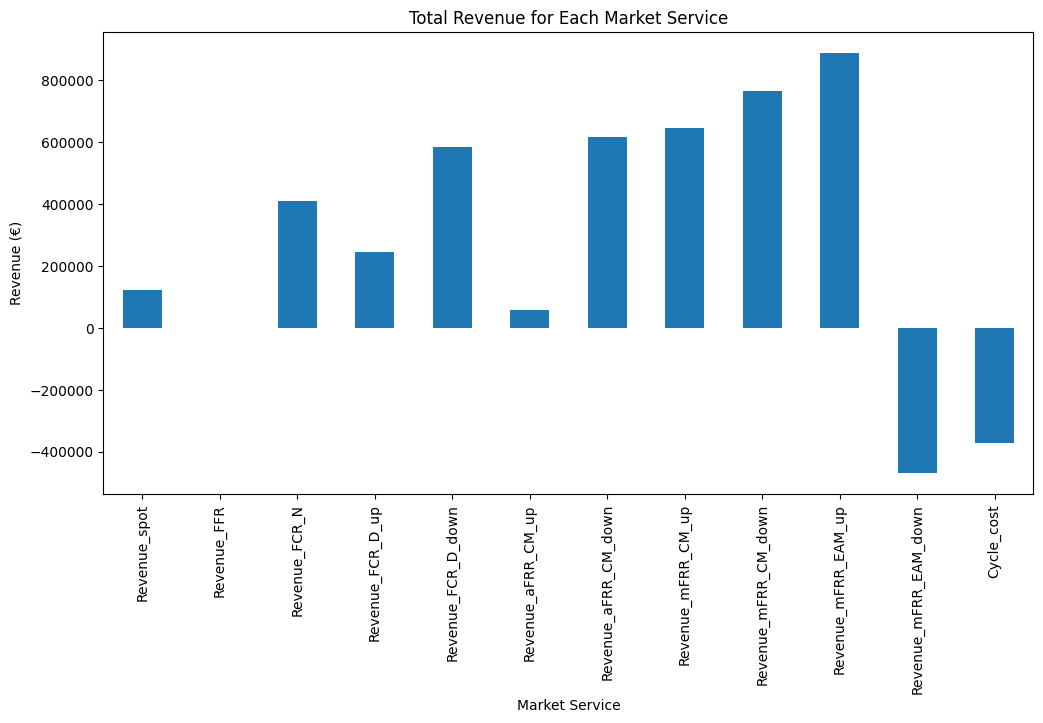

In [15]:
# Calculate the total revenue for each market 
print("The total revenue for each market service is:")
print(revenue_df_year[['Revenue_FFR', 'Revenue_FCR_N', 'Revenue_FCR_D_up', 'Revenue_FCR_D_down', 'Revenue_aFRR_CM_up', 'Revenue_aFRR_CM_down', 'Revenue_mFRR_CM_up', 'Revenue_mFRR_CM_down', 'Revenue_mFRR_EAM_up', 'Revenue_mFRR_EAM_down', 'Cycle_cost']].sum())

# plot them 
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the total revenue for each market service
revenue_df_year[['Revenue_spot','Revenue_FFR', 'Revenue_FCR_N', 'Revenue_FCR_D_up', 'Revenue_FCR_D_down', 'Revenue_aFRR_CM_up', 'Revenue_aFRR_CM_down', 'Revenue_mFRR_CM_up', 'Revenue_mFRR_CM_down', 'Revenue_mFRR_EAM_up', 'Revenue_mFRR_EAM_down', 'Cycle_cost']].sum().plot(kind='bar', ax=ax)

# Set the title and labels
ax.set_title('Total Revenue for Each Market Service')
ax.set_ylabel('Revenue (€)')
ax.set_xlabel('Market Service')

# Display the plot
plt.show()

